In [2]:
import json
from os import environ

from aiohttp.client_reqrep import json_re
from langchain_core.messages import ToolMessage
from langgraph.constants import START
from typing_extensions import TypedDict, Annotated

In [4]:
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # Messages have the type list The add_messages function
    #in the annoation defines how this state key should be updated
    #(in this casse,it appends messages to the list,ranther than overwriting #them)
    messages: Annotated[list,add_messages]

graph_builder = StateGraph(State)


In [5]:
from app.agents.lib.llm.llm import LLMFactory
llm = LLMFactory.getDefaultOPENAI()
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

OPENAI_BASE_URL:
https://www.dmxapi.cn/v1


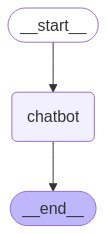

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
from langchain_core.messages import ToolMessage
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break




User: What do you know about LangGraph?
Assistant: 



KeyboardInterrupt



In [17]:
!pip install -U tavily-python langchain_community

  Using cached numpy-2.2.4-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.49
    Uninstalling langchain-core-0.3.49:
      Successfully uninstalled langchain-core-0.3.49
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.7
    Uninstalling langchain-text-splitters-0.3.7:
      Successfully uninstalled langchain-text-splitters-0.3.7
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.21
    Uninstalling langchain-0.3.21:
      Successfully uninstalled langchain-0.3.21


In [15]:
import os

os.environ["TAVILY_API_KEY"] = "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"


In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)from langchain_core.runnables import RunnableConfig [...] By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol\' Python code.\nIn short: nodes do the work. edges tell what to do next. [...] Nodes: Python functions that enco

In [20]:
from typing import Annotated
from typing_extensions import TypedDict
from app.agents.lib.llm.llm import LLMFactory
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm =LLMFactory.getDefaultOPENAI()
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)


OPENAI_BASE_URL:
https://www.dmxapi.cn/v1


In [27]:
import json
class BasicToolNode:
    """
    A node that runs the tools requested in the last AIMessage.
    """
    def __init__(self,tools:list)->None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs:dict):
        if messages := inputs.get("messages",[]):
            messages = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in messages.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages":outputs}
tool_node =   BasicToolNode(tools=[tool])
graph_builder.add_node("tools",tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `tools` already present.

In [22]:
def route_tools(

    state: State,

):

    """

    Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end.

    """

    if isinstance(state, list):

        ai_message = state[-1]

    elif messages := state.get("messages", []):

        ai_message = messages[-1]

    else:

        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:

        return "tools"

    return END





# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if

# it is fine directly responding. This conditional routing defines the main agent loop.

graph_builder.add_conditional_edges(

    "chatbot",

    route_tools,

    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node

    # It defaults to the identity function, but if you

    # want to use a node named something else apart from "tools",

    # You can update the value of the dictionary to something else

    # e.g., "tools": "my_tools"

    {"tools": "tools", END: END},

)

# Any time a tool is called, we return to the chatbot to decide the next step

graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()


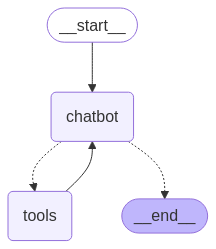

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: 请提供您想查询的信息或问题，我会尽力帮助您找到答案。
Assistant: 
Assistant: "SSLError(MaxRetryError(\"HTTPSConnectionPool(host='api.tavily.com', port=443): Max retries exceeded with url: /search (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))\"))"
Assistant: It seems there was an issue retrieving the current price of Ethereum (ETH) due to a connection error. You might want to check a reliable financial website or cryptocurrency exchange for the latest price information.
Assistant: 请问有什么我可以帮助您的吗？
Assistant: 请提供您想查询的具体内容或问题，以便我能更好地帮助您。
Assistant: 
Assistant: [{"title": "Bitcoin Price, BTC Price Chart & Marketcap - KuCoin", "url": "https://www.kucoin.com/price/BTC", "content": "Bitcoin Price\n(BTC)\nUSD($)\nBitcoin (BTC) Live Price Chart\nOverview\nAbout\nAnalysis\nFAQ\nBitcoin Live Price Data\nThe live price of Bitcoin is $86,863.7, with a total trading volume of $ 340.45M in th